# $T_2$ map calculation tutorial
There are two methods of calculating $T_2$ maps in `ukat`, a standard curve fitting approach (with multiple models
available) or the `StimFit` approach that models stimulated echoes in the refocusing pulse train using extended phase graphs
 as in [Marc Lebel R. StimFit: A Toolbox for Robust T2 Mapping with Stimulated Echo Compensation. In: Proc. Intl. Soc. Mag.
 Reson. Med. 20. Melbourne; 2012:2558](https://archive.ismrm.org/2012/2558.html).

In this tutorial we'll demonstrate both methods on example renal data.

## Curve Fitting Methods
Start by importing the required libraries and defining some settings:

In [1]:
import os
import matplotlib.pyplot as plt

from ukat.data import fetch
from ukat.mapping.t2 import T2

# Ensure figures are rendered in the notebook
%matplotlib inline

Tell python where to store the $T_2$ maps NIfTI files we will generate. We will store it in a directory called 
`t2_calculation_output` in the `tutorials` directory.

In [2]:
# Initialise output path for T2 map
directory = 't2_calculation_output'
os.makedirs(directory, exist_ok=True)
OUTPUT_DIR = os.path.join(os.getcwd(), directory)

Retrieve $T_2$ test data using our data fetcher. The first time the fetcher is run, it will download the data from the
internet, after that it will just use the cached local data.

This will return 3 variables:
* `image`: a 4D array with the magnitude data at all echo times.
* `affine`: the affine matrix for the data (needed to later write a new NIfTI file).
* `te`: an array containing the echo times, in seconds.

In [3]:
# Fetch test data
image, affine, te = fetch.t2_philips(2)
te = te * 1000  # convert TE to ms
mask = image[..., 0] > 20000 # Generate a mask based on the signal intensity of the first echo

Compute the $T_2$ maps using the `T2` class implemented in `mapping`.

Multiple models are available to fit data to. `2p_exp` fits the data to equation $S = S_0 \cdot e^{\frac{-t}{T2}}$ and 
`3p_exp` fits the data to equation $S = S_0 \cdot e^{\frac{-t}{T2}}+b$ where $b$ is a baseline noise term comprising of 
noise and very long $T_2$ components. Additionally, a noise threshold can be specified to ommit late echos when the signal
has recovered to the noise floor from the fitting process.

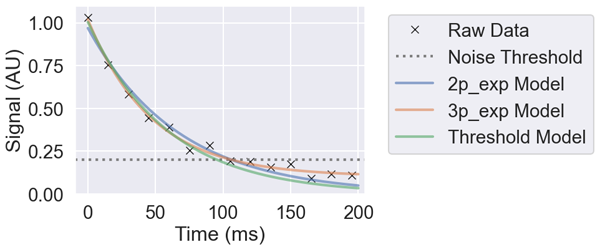

In this tutorial we will compare the `2p_exp` and `3p_exp` models.

In [4]:
# Initialise the mapping objects. This step can take a while as its calculating the T2 for every voxel in the image
mapper_2p = T2(image, te, affine, mask, method='2p_exp')
mapper_3p = T2(image, te, affine, mask, method='3p_exp')

# Save output maps to Nifti
mapper_2p.to_nifti(output_directory=OUTPUT_DIR, base_file_name='two_param_curve_fit', maps='all')
mapper_3p.to_nifti(output_directory=OUTPUT_DIR, base_file_name='three_param_curve_fit', maps='all')

Display a central slice of the $T_2$ maps and derived measures.

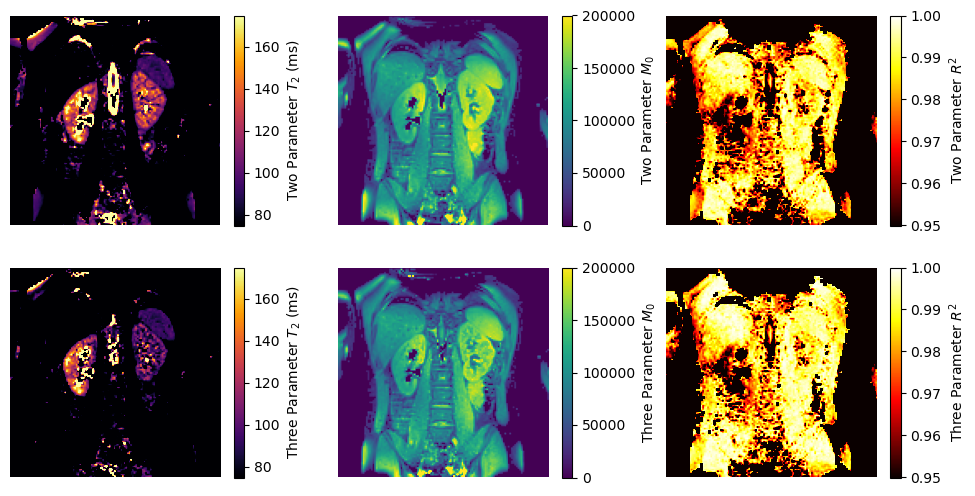

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

# Display a central slice of the two parameter T2 map
im = ax[0, 0].imshow(mapper_2p.t2_map[:, :, 2].T, origin='lower', cmap='inferno', clim=(75, 175))
cb = fig.colorbar(im, ax=ax[0, 0])
cb.set_label('Two Parameter $T_2$ (ms)')
ax[0, 0].axis('off')

# Display a central slice of the two parameter M0 map
im = ax[0, 1].imshow(mapper_2p.m0_map[:, :, 2].T, origin='lower', cmap='viridis', clim=(0, 200000))
cb = fig.colorbar(im, ax=ax[0, 1])
cb.set_label('Two Parameter $M_0$')
ax[0, 1].axis('off')

# Display a central slice of the two parameter r-squared map
im = ax[0, 2].imshow(mapper_2p.r2[:, :, 2].T, origin='lower', cmap='hot', clim=(0.95, 1))
cb = fig.colorbar(im, ax=ax[0, 2])
cb.set_label('Two Parameter $R^2$')
ax[0, 2].axis('off')

# Display a central slice of the three parameter T2 map
im = ax[1, 0].imshow(mapper_3p.t2_map[:, :, 2].T, origin='lower', cmap='inferno', clim=(75, 175))
cb = fig.colorbar(im, ax=ax[1, 0])
cb.set_label('Three Parameter $T_2$ (ms)')
ax[1, 0].axis('off')

# Display a central slice of the three parameter M0 map
im = ax[1, 1].imshow(mapper_3p.m0_map[:, :, 2].T, origin='lower', cmap='viridis', clim=(0, 200000))
cb = fig.colorbar(im, ax=ax[1, 1])
cb.set_label('Three Parameter $M_0$')
ax[1, 1].axis('off')

# Display a central slice of the two parameter r-squared map
im = ax[1, 2].imshow(mapper_3p.r2[:, :, 2].T, origin='lower', cmap='hot', clim=(0.95, 1))
cb = fig.colorbar(im, ax=ax[1, 2])
cb.set_label('Three Parameter $R^2$')
ax[1, 2].axis('off')

plt.show()

## StimFit
Now we'll use the stimulated echo fitting approach on the same data. This method uses information about the excitation and refocusing RF pulses to minimise the confounding effects of stimulated echoes in the multi-echo pulse train and estimate $T_2$, $B_1^+$ and $M_0$. For the UKRIN-MAPS $T_2$ mapping sequence, the RF pulse profiles and default values are all easily accessible via the `ukrin_vendor` property, however adapted sequences should have these parameters input to the model manually.

In [6]:
from ukat.mapping.t2_stimfit import StimFitModel, T2StimFit
model = StimFitModel(mode='selective', ukrin_vendor='philips')
mapper_stimfit = T2StimFit(image, affine, model, mask)
mapper_stimfit.to_nifti(output_directory=OUTPUT_DIR, base_file_name='stimfit')

Lets display the central slice of the generated maps.

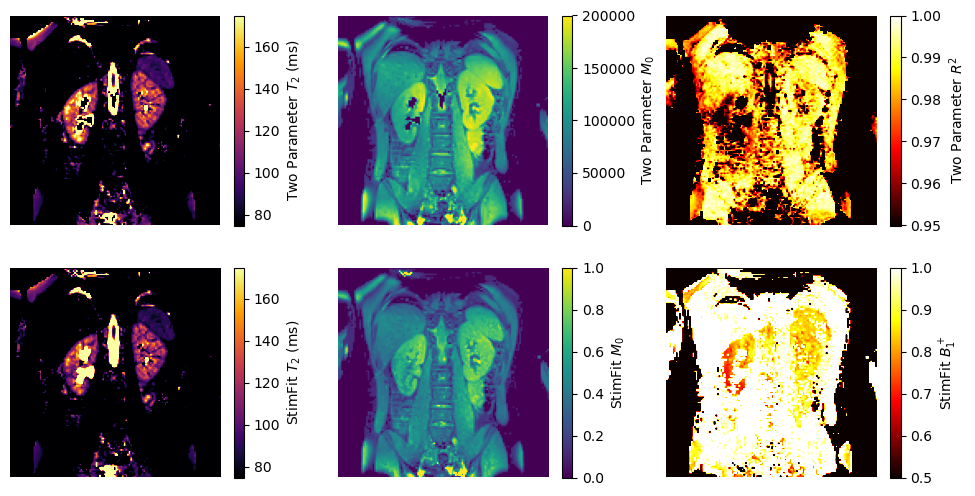

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

# Display a central slice of the two parameter T2 map
im = ax[0, 0].imshow(mapper_2p.t2_map[:, :, 2].T, origin='lower', cmap='inferno', clim=(75, 175))
cb = fig.colorbar(im, ax=ax[0, 0])
cb.set_label('Two Parameter $T_2$ (ms)')
ax[0, 0].axis('off')

# Display a central slice of the two parameter M0 map
im = ax[0, 1].imshow(mapper_2p.m0_map[:, :, 2].T, origin='lower', cmap='viridis', clim=(0, 200000))
cb = fig.colorbar(im, ax=ax[0, 1])
cb.set_label('Two Parameter $M_0$')
ax[0, 1].axis('off')

# Display a central slice of the two parameter r-squared map
im = ax[0, 2].imshow(mapper_2p.r2[:, :, 2].T, origin='lower', cmap='hot', clim=(0.95, 1))
cb = fig.colorbar(im, ax=ax[0, 2])
cb.set_label('Two Parameter $R^2$')
ax[0, 2].axis('off')

# Display a central slice of the stimfit T2 map
im = ax[1, 0].imshow(mapper_stimfit.t2_map[:, :, 2].T, origin='lower', cmap='inferno', clim=(75, 175))
cb = fig.colorbar(im, ax=ax[1, 0])
cb.set_label('StimFit $T_2$ (ms)')
ax[1, 0].axis('off')

# Display a central slice of the stimfit M0 map
im = ax[1, 1].imshow(mapper_stimfit.m0_map[:, :, 2].T, origin='lower', cmap='viridis', clim=(0, 1))
cb = fig.colorbar(im, ax=ax[1, 1])
cb.set_label('StimFit $M_0$')
ax[1, 1].axis('off')

# Display a central slice of the stimfit B1 map
im = ax[1, 2].imshow(mapper_stimfit.b1_map[:, :, 2].T, origin='lower', cmap='hot', clim=(0.5, 1))
cb = fig.colorbar(im, ax=ax[1, 2])
cb.set_label('StimFit $B_1^+$')
ax[1, 2].axis('off')

plt.show()